In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - orbital_parameters.ipynb
# AUTHOR - James Lane
# PROJECT - OHStars
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Generate orbital parameters for the 6 outer halo stars. Sample 5D gaia kinematics with covariances and
determine orbital parameters and uncertainties using a MC approach.
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, warnings
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import table
from astropy import units as apu
from astropy.utils.exceptions import AstropyWarning

## galpy
from galpy import orbit
from galpy import potential
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv
from galpy.util import bovy_plot as gpplot

# Project-specific
sys.path.append('../../src')
import ohstars.analysis

In [3]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta
## Future Work

## Information
- Gaia co-variance information: https://www.aanda.org/articles/aa/pdf/2012/07/aa18807-12.pdf

# Preparation
## Keywords

In [29]:
# Number of samples
n_samples = 100

# Perform the analysis on all stars? False for skip
include_stars = [True, True, True, True, True, True]

# Integration keywords
t_orbit = [2,10,1,40,3,2] # Gyr

# Declare the potential
pot = potential.MWPotential2014


## Read Data

In [30]:
# Filename
filename = '../../data/gaia/allstars.vot'

# Read the file
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    tab = table.Table.read(filename)
    
n_stars = len(tab) # 6
star_names = tab['col1'].data.astype(str)

## Prepare RV Data

In [31]:
# RV is uncorrelated with gaia so sample individually. From some Table I have (ref? In paper?)
vrad = np.array([-314.41, -136.80, -361.75, -372.09, -321.48, -214.37 ])
vrad_err = np.array([0.26,0.14,0.67,0.32,0.28,0.26])

# Integrate
Loop over each star and determine orbital parameters

A Jupyter Widget

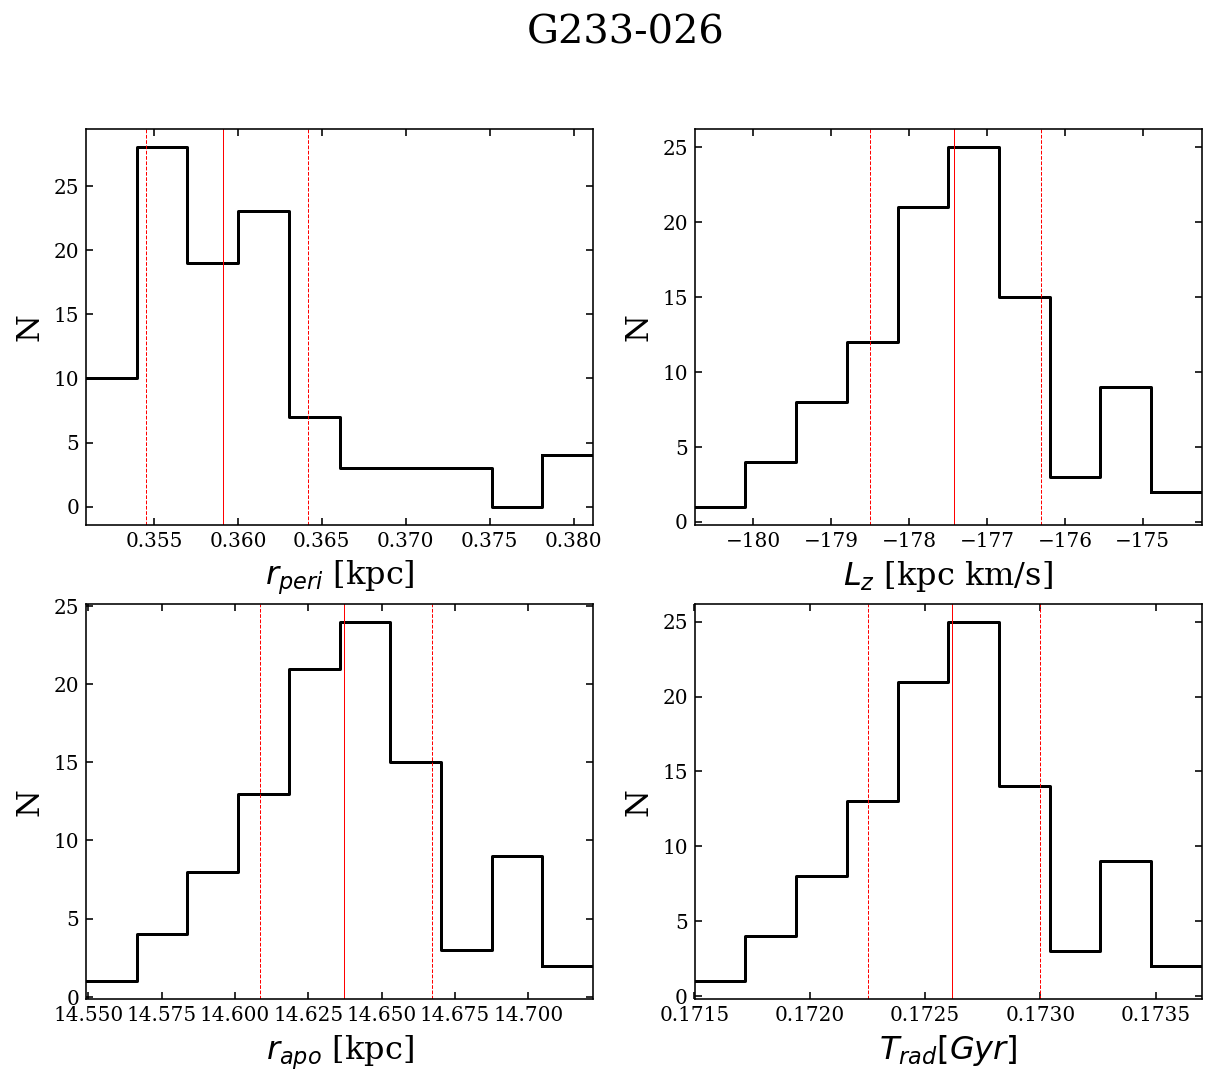

G233-026
rp [kpc]
Median: 0.3591
Central 68th percentile: [0.3545,0.3642]
Errors: [-0.0045,0.0051]

rapo [kpc]
Median: 14.6372
Central 68th percentile: [14.6085,14.6673]
Errors: [-0.0286,0.0301]

Lz [kpc km/s]
Median: -177.4193
Central 68th percentile: [-178.5021,-176.3128]
Errors: [-1.0828,1.1064]

Tr [Gyr]
Median: 0.1726
Central 68th percentile: [0.1723,0.173]
Errors: [-0.0004,0.0004]



A Jupyter Widget

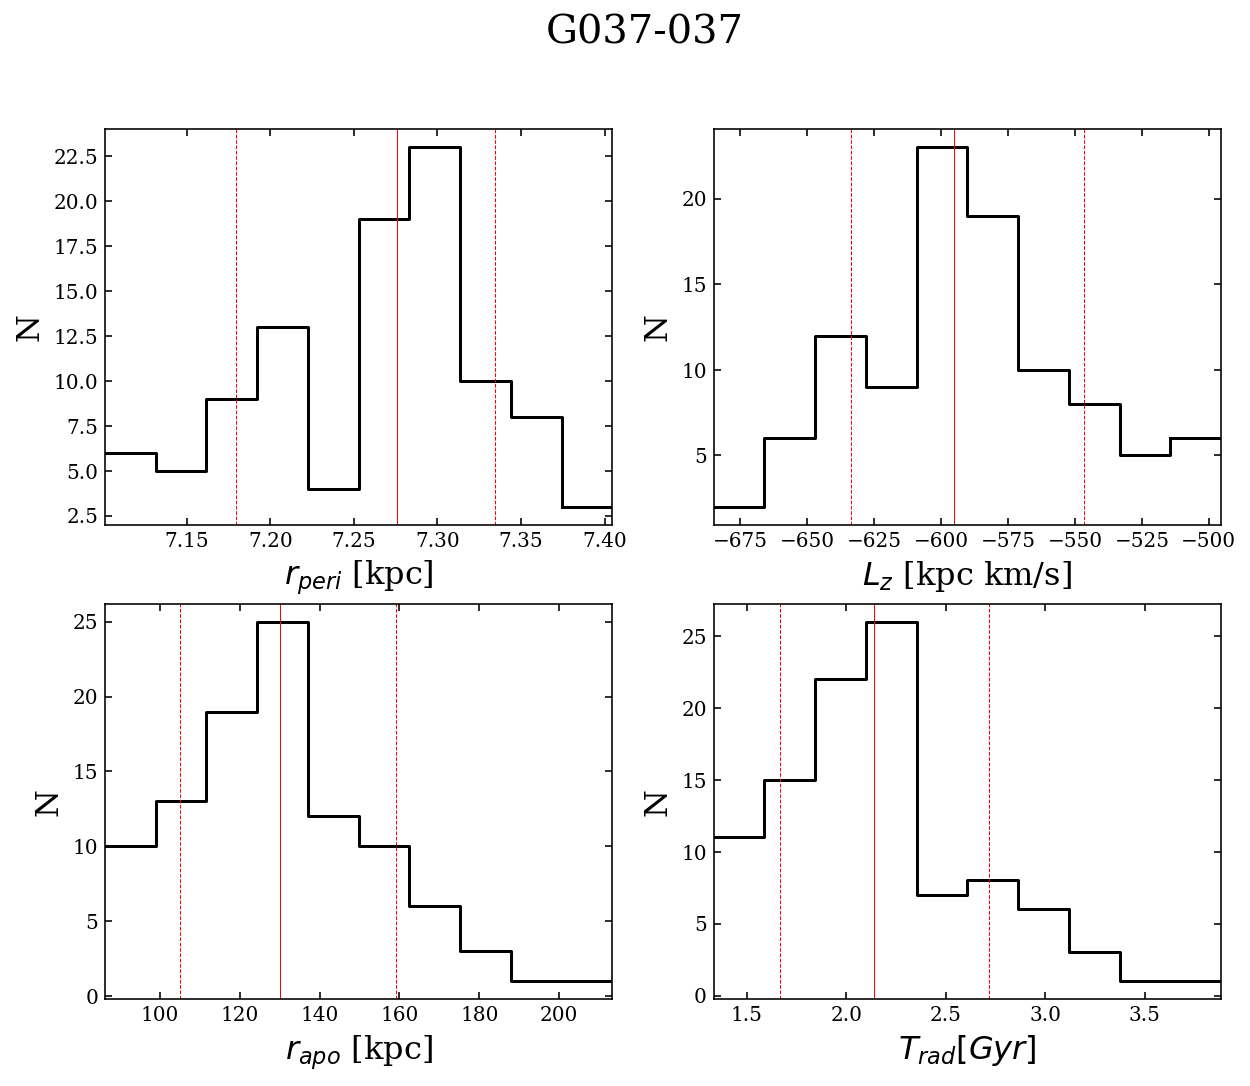

G037-037
rp [kpc]
Median: 7.2758
Central 68th percentile: [7.1797,7.3344]
Errors: [-0.0961,0.0586]

rapo [kpc]
Median: 130.04
Central 68th percentile: [105.0835,159.1239]
Errors: [-24.9565,29.0839]

Lz [kpc km/s]
Median: -595.0975
Central 68th percentile: [-633.5673,-546.5667]
Errors: [-38.4699,48.5308]

Tr [Gyr]
Median: 2.1382
Central 68th percentile: [1.669,2.718]
Errors: [-0.4691,0.5798]



A Jupyter Widget

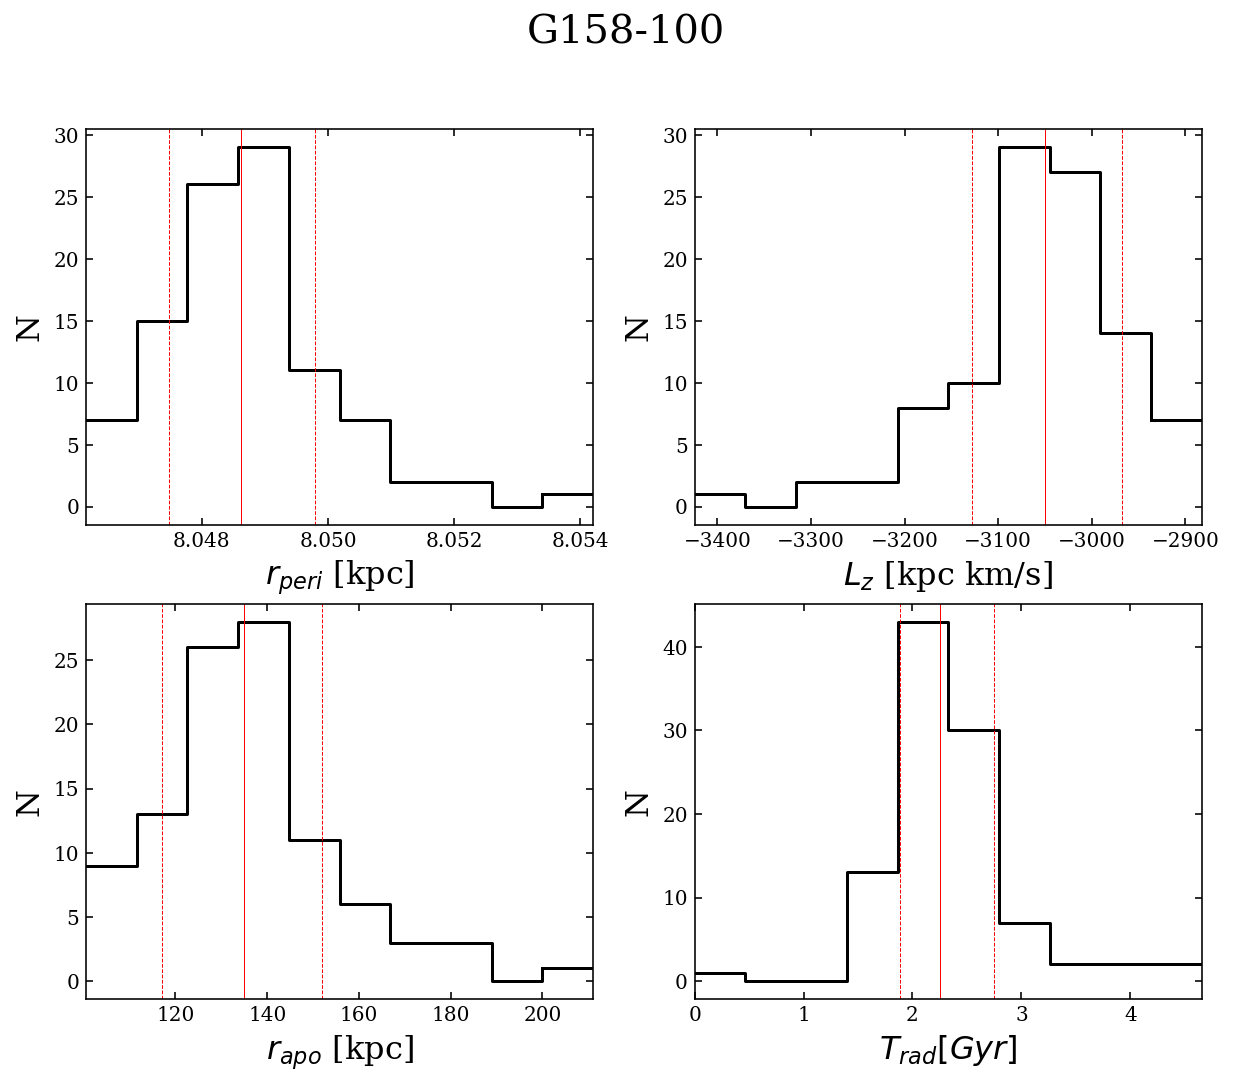

G158-100
rp [kpc]
Median: 8.0486
Central 68th percentile: [8.0475,8.0498]
Errors: [-0.0011,0.0012]

rapo [kpc]
Median: 135.0104
Central 68th percentile: [117.0927,152.0098]
Errors: [-17.9177,16.9995]

Lz [kpc km/s]
Median: -3050.1416
Central 68th percentile: [-3128.0633,-2967.6679]
Errors: [-77.9218,82.4737]

Tr [Gyr]
Median: 2.2559
Central 68th percentile: [1.8825,2.7498]
Errors: [-0.3734,0.4939]



A Jupyter Widget

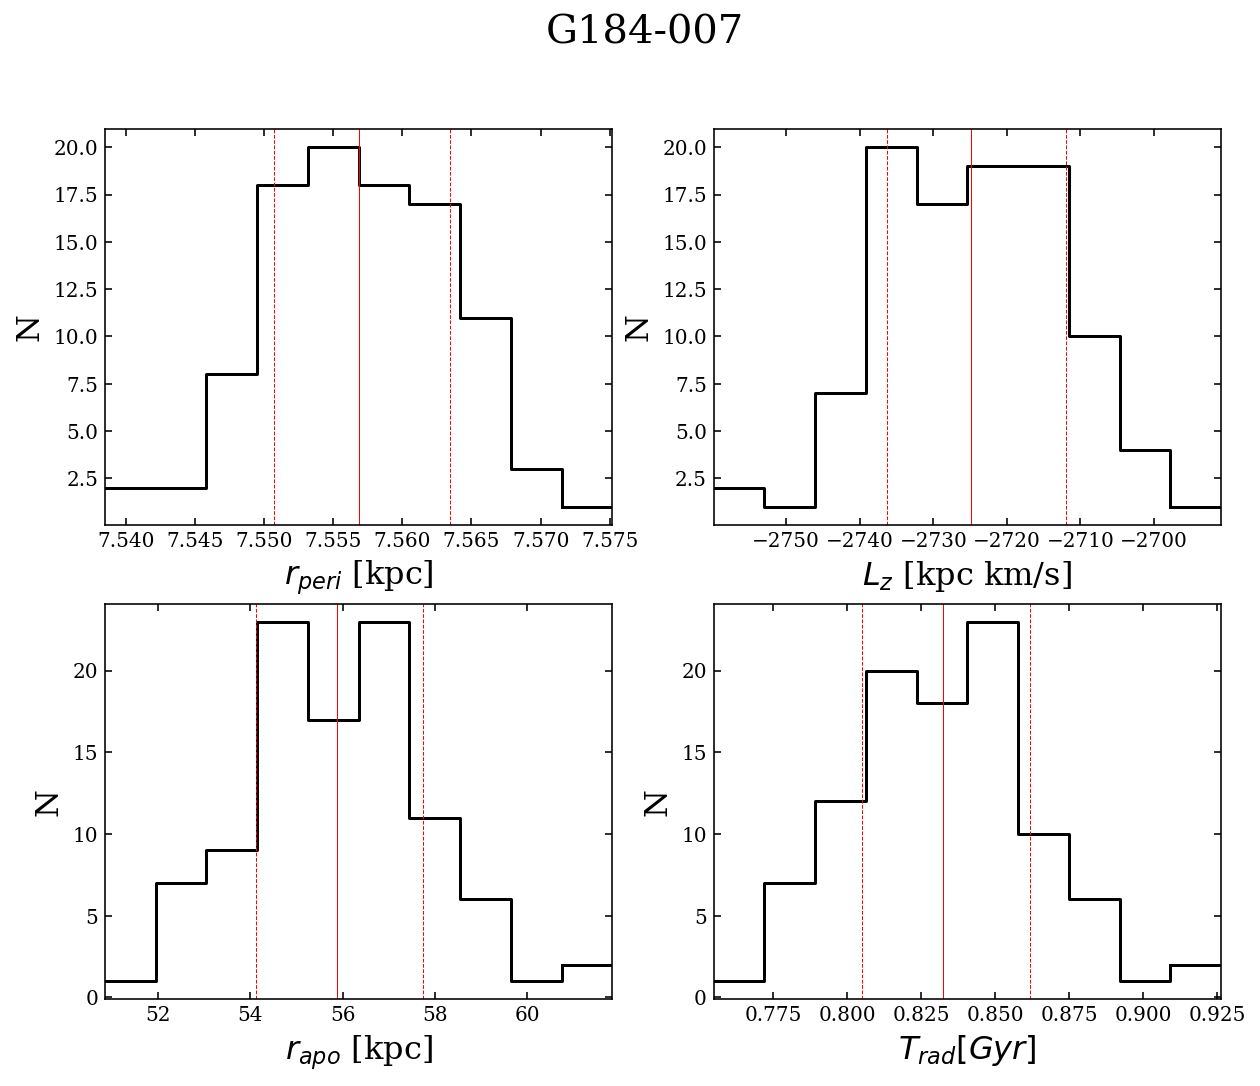

G184-007
rp [kpc]
Median: 7.5568
Central 68th percentile: [7.5507,7.5634]
Errors: [-0.0061,0.0066]

rapo [kpc]
Median: 55.8722
Central 68th percentile: [54.1169,57.7519]
Errors: [-1.7553,1.8798]

Lz [kpc km/s]
Median: -2724.8637
Central 68th percentile: [-2736.3031,-2711.9078]
Errors: [-11.4394,12.9559]

Tr [Gyr]
Median: 0.8323
Central 68th percentile: [0.8051,0.8617]
Errors: [-0.0272,0.0293]



A Jupyter Widget

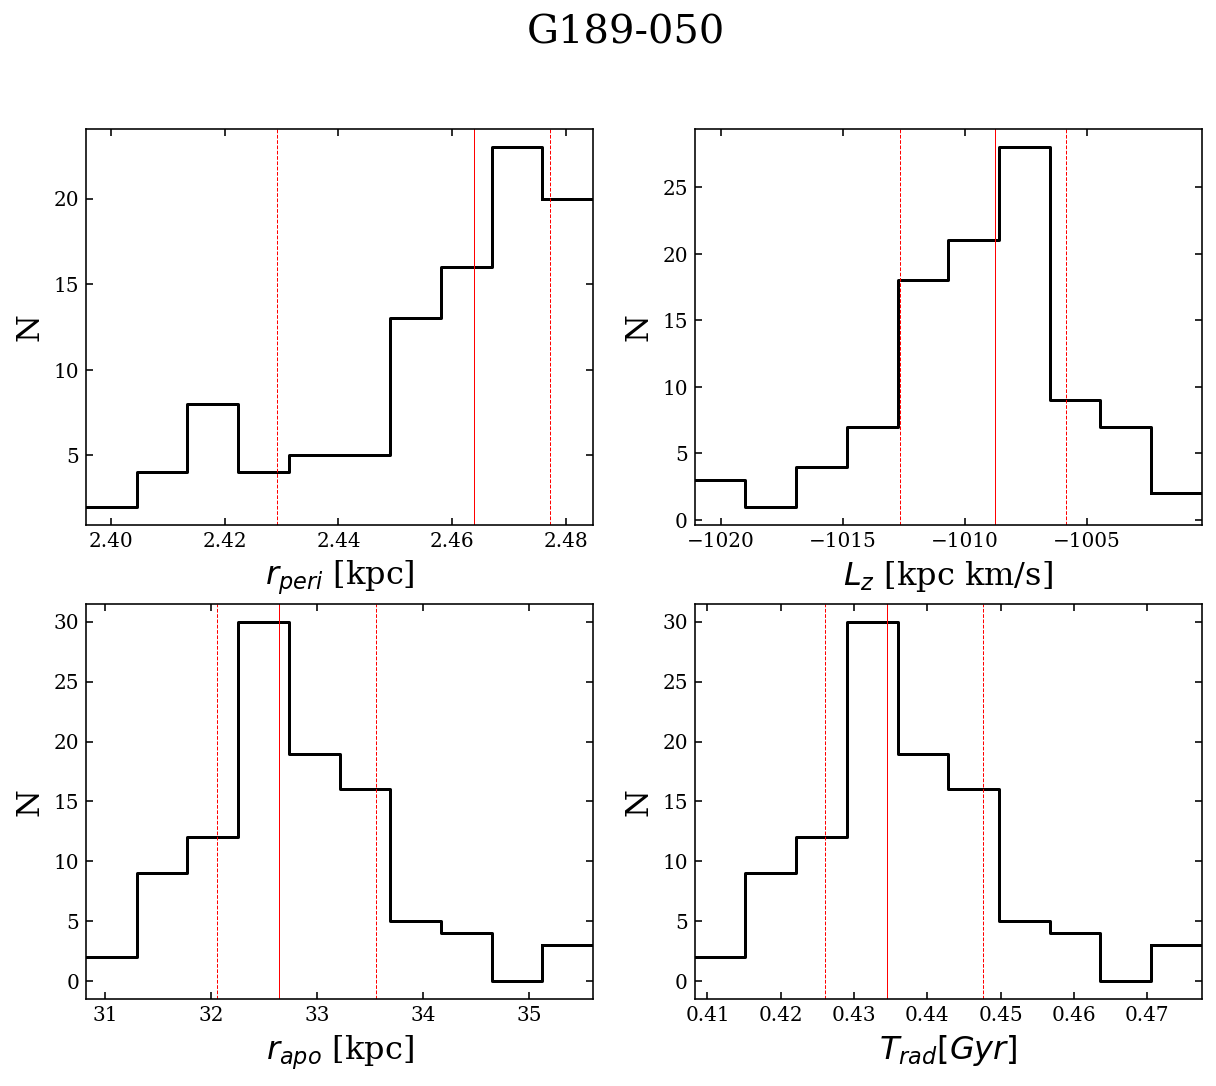

G189-050
rp [kpc]
Median: 2.4637
Central 68th percentile: [2.4292,2.4772]
Errors: [-0.0345,0.0135]

rapo [kpc]
Median: 32.635
Central 68th percentile: [32.0532,33.55]
Errors: [-0.5818,0.915]

Lz [kpc km/s]
Median: -1008.7589
Central 68th percentile: [-1012.6595,-1005.8611]
Errors: [-3.9006,2.8979]

Tr [Gyr]
Median: 0.4345
Central 68th percentile: [0.426,0.4477]
Errors: [-0.0084,0.0132]



A Jupyter Widget

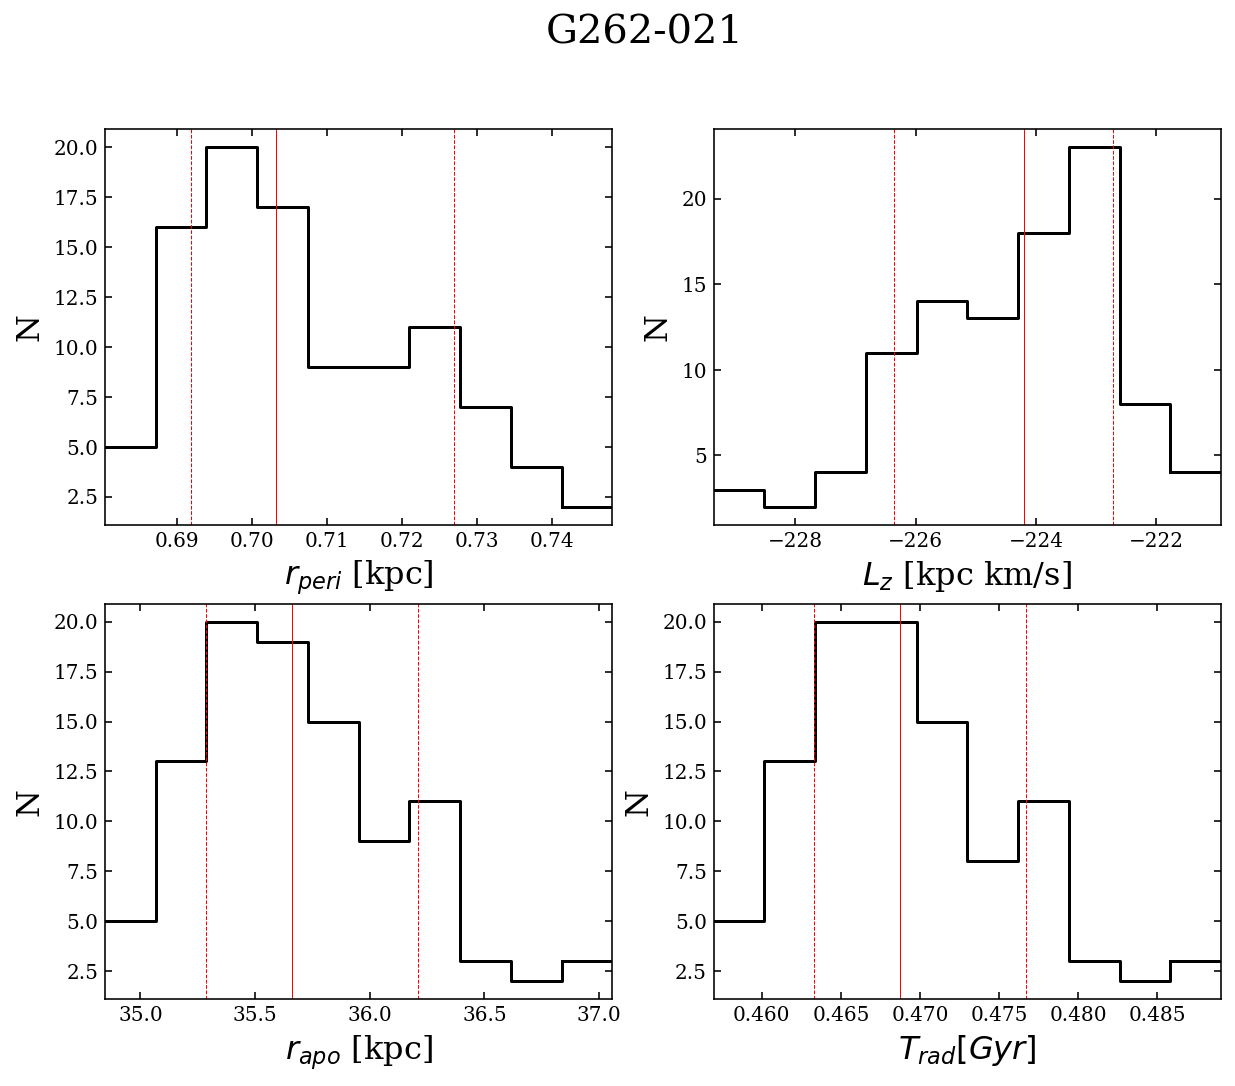

G262-021
rp [kpc]
Median: 0.7033
Central 68th percentile: [0.692,0.7269]
Errors: [-0.0113,0.0237]

rapo [kpc]
Median: 35.6612
Central 68th percentile: [35.2867,36.2094]
Errors: [-0.3745,0.5482]

Lz [kpc km/s]
Median: -224.1984
Central 68th percentile: [-226.3526,-222.722]
Errors: [-2.1542,1.4764]

Tr [Gyr]
Median: 0.4688
Central 68th percentile: [0.4633,0.4767]
Errors: [-0.0054,0.008]



In [37]:
for i in range(n_stars):
    
    # Make the figure
    fig = plt.figure( figsize=(10,8) )
    axs = fig.subplots( nrows=2, ncols=2 )
    
    # Evaluate?
    if include_stars[i] == False:
        continue
    ##fi
    
    # Sample the data
    samples, _ = ohstars.analysis.sample_kinematics( tab[i], n_samples=n_samples )
    rv_samples = np.random.normal( vrad[i], vrad_err[i], size=n_samples )
    
    # Timing:
    n_snaps = 1000 * t_orbit[i] # 1/Myr
    times = np.linspace(0,t_orbit[i],n_snaps) * apu.Gyr
    
    # Arrays to hold output parameters
    peri = np.zeros(n_samples)
    apo = np.zeros(n_samples)
    Lz = np.zeros(n_samples)
    Tr = np.zeros(n_samples)
    
    # Loop over the trials
    for j in tqdm_nb( range(n_samples) ):
        
        # Unpack the sample:
        ra, dec, par, pmra, pmdec = samples[j]
        rv = rv_samples[i]
        dist = 1/par # In kpc
        
        # Now declare the orbit
        o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True )
        
        # Integrate
        o.integrate(times, pot)
        
        # Output
        peri[j] = o.rperi().value # Kpc
        apo[j] = o.rap().value # Kpc
        Lz[j] = np.average( o.vT(times) * o.R(times) ).value # Kpc Km/s
        Tr[j] = o.Tr(pot=pot, type='staeckel').value # Gyr
    
    # Determine values to plot and calculate
    plot_params = np.array([peri,apo,Lz,Tr])
    plot_labels = np.array([r'$r_{peri}$ [kpc]',
                            r'$r_{apo}$ [kpc]',
                            r'$L_{z}$ [kpc km/s]',
                            r'$T_{rad} [Gyr]$']) 
    plot_labels_plain = np.array(['rp [kpc]','rapo [kpc]','Lz [kpc km/s]','Tr [Gyr]'])
    
    # Arrays for statistics
    medians = np.zeros(4)
    cen_68th_perc = np.zeros((4,2))
    
    # Loop over all axes
    for k in range(2):
        for l in range(2):
            
            # Get parameter and compute statistics
            param = plot_params[2*k+l]    
            param_median = np.median(param)
            param_c68p_l = np.sort(param)[int(0.16*n_samples)]
            param_c68p_u = np.sort(param)[int(0.84*n_samples)]
            
            # Make histograms
            bin_n, bins = np.histogram( param )
            axs[l,k].step(bins[:-1], bin_n, where='post', color='Black')
            axs[l,k].plot([bins[-2],bins[-1]], [bin_n[-1],bin_n[-1]], color='Black')
            axs[l,k].axvline( param_median, linestyle='solid', color='Red', linewidth=0.5 )
            axs[l,k].axvline( param_c68p_l, linestyle='dashed', color='Red', linewidth=0.5 )
            axs[l,k].axvline( param_c68p_u, linestyle='dashed', color='Red', linewidth=0.5 )
            axs[l,k].set_xlim( np.min(param), np.max(param) )
            axs[l,k].set_xlabel(plot_labels[2*k+l], fontsize=16)
            axs[l,k].set_ylabel('N', fontsize=16)
    
            # Save
            medians[2*k+l] = param_median
            cen_68th_perc[2*k+l,0] = param_c68p_l
            cen_68th_perc[2*k+l,1] = param_c68p_u
            
    fig.savefig('plots/'+star_names[i]+'_orbital_param_pdf.pdf')
    fig.suptitle(star_names[i], fontsize=20)
    
    plt.show()
    plt.close('all')
    
    # Print information
    print(star_names[i])
    print('========')
    for k in range(2):
        for l in range(2):
            
            print(plot_labels_plain[2*k+l])
            print('Median: '+str(round(medians[2*k+l],4)))
            print('Central 68th percentile: ['+str(round(cen_68th_perc[2*k+l,0],4))+','+str(round(cen_68th_perc[2*k+l,1],4))+']')
            print('Errors: ['+str(round(cen_68th_perc[2*k+l,0]-medians[2*k+l],4))+','+str(round(cen_68th_perc[2*k+l,1]-medians[2*k+l],4))+']\n')
        ###l
    ###k

# No output
pass;